# Replication notebook - UrbanSim maps

Sam Maurer, December 2017, Python 3.6

In [2]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandana as pdna
import pandas as pd

## Load building data from Bay Area UrbanSim

This data is from Bay Area UrbanSim: https://github.com/UDST/bayarea_urbansim

There is not currently a public download because certain contents of the h5 file are proprietary, but MTC should be willing to share the data required for this analysis. All we use are `building_type_id` from the buildings table and the `x` and `y` coordinates from the parcels table.

In [19]:
path = '/Users/smmaurer/Dropbox/Data/MTC/UrbanSim/2015_09_01_bayarea_v3.h5'
store = pd.HDFStore(path)
print(store.keys())

['/buildings', '/households', '/jobs', '/jobs_urbansim_allocated', '/parcels', '/zones']


In [4]:
parcels = pd.read_hdf(store, 'parcels')
print(len(parcels))
print(parcels.columns.tolist())

1956212
['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id', 'proportion_undevelopable', 'tax_exempt_status', 'apn', 'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area']


In [5]:
buildings = pd.read_hdf(store, 'buildings')
print(len(buildings))
print(buildings.columns.tolist())

1843351
['parcel_id', 'development_type_id', 'improvement_value', 'residential_units', 'residential_sqft', 'sqft_per_unit', 'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type', 'costar_property_type', 'costar_rent', 'building_type_id']


In [6]:
merged = buildings.merge(parcels, how='left', left_on='parcel_id', right_index=True)
print(len(merged))

1843351


## Set up Pandana for accessibility calculations

This uses the OSM street network from Bay Area UrbanSim: https://github.com/UDST/bayarea_urbansim

In [7]:
path = '/Users/smmaurer/Dropbox/Data/MTC/UrbanSim/2015_06_01_osm_bayarea4326.h5'
store = pd.HDFStore(path, "r")
nodes = store.nodes
edges = store.edges
print(nodes.head(3))
print(edges.head(3))

             x          y
8  -121.546785  36.997092
9  -121.548863  36.999641
10 -121.550719  37.002132
   from  to      weight
6     8   9  338.255005
7     9  10  322.532990
8    10  11  218.505997


In [8]:
%%time
net=pdna.Network(nodes["x"], nodes["y"], edges["from"], edges["to"], edges[["weight"]])

CPU times: user 9.78 s, sys: 155 ms, total: 9.93 s
Wall time: 9.92 s


In [9]:
%%time
net.precompute(5000)

CPU times: user 47 s, sys: 2.31 s, total: 49.3 s
Wall time: 49.1 s


## Calculate accessibility to retail buildings

This is a proxy for accessibility to shopping, and only a small component of a good housing price model, but there will still be some correlation.

Key for `building_type_id` and `building_type`

````
01 - HS - single-family
02 - HT - townhomes
03 - HM - multi-family
04 - OF - office
05 - HO - hotel
06 - SC - school
07 - IL - light industrial
08 - IW - warehouse industrial
09 - IH - heavy industrial
10 - RS - retail strip
11 - RB - retail big box
12 - MR - mixed use residential focused
13 - MT - mixed use retail focused
14 - ME - mixed use employment focused
15 - PA - parking
16 - PA2 - parking
````

In [10]:
retail = merged.loc[merged.building_type_id.isin([10,11,12,13])].copy()
print(len(retail))

38792


In [11]:
# Link to panadana network
retail['node_ids'] = net.get_node_ids(retail.x, retail.y)
net.set(retail.node_ids, name='retail')

In [12]:
%%time
access = net.aggregate(5000, type='sum', decay='flat', name='retail').rename('retail').to_frame()
access = pd.merge(access, nodes, how='left', left_index=True, right_index=True)
print(len(access))
print(access.head())

226060
    retail           x          y
8    291.0 -121.546785  36.997092
9    299.0 -121.548863  36.999641
10   317.0 -121.550719  37.002132
11   324.0 -121.550795  37.004075
12   326.0 -121.550784  37.004226
CPU times: user 3.45 s, sys: 5.01 s, total: 8.46 s
Wall time: 8.46 s


## Load rental data

This uses several months of Craigslist rental listings, from the Urban Analytics Lab fork of Bay Area UrbanSim: https://github.com/ual/bayarea_urbansim/raw/ual-development/data/sfbay_craigslist.csv

In [13]:
rentals = pd.read_csv('/Users/smmaurer/Dropbox/Data/UAL/Craigslist/sfbay_craigslist.csv')
print(len(rentals))
print(rentals.head(3))

73644
               neighborhood   price  bedrooms        date  sqft_per_unit  \
0  twin peaks / diamond hts  4500.0       2.0  2014-05-11         1200.0   
1                 sunnyvale  2650.0       2.0  2014-05-11         1040.0   
2                 glen park  3100.0       2.0  2014-05-11         1000.0   

          lon        lat  price_per_sqft  
0 -122.438300  37.745000        3.750000  
1 -122.008131  37.353699        2.548077  
2 -122.439743  37.731584        3.100000  


In [14]:
rentals.price_per_sqft.describe()

count    73644.000000
mean         4.697802
std        183.768413
min          0.000154
25%          2.055256
50%          2.587519
75%          3.135714
max      31145.389277
Name: price_per_sqft, dtype: float64

## Load coastline

This uses a US Census cartographic shapefile: https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html

In [15]:
# Census state outlines
path = '/Users/smmaurer/Dropbox/Data/Census shapefiles/cb_2016_us_state_500k/cb_2016_us_state_500k.shp'
states = gpd.read_file(path)
print(len(states))
print(states.columns)

56
Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


## Generate figure

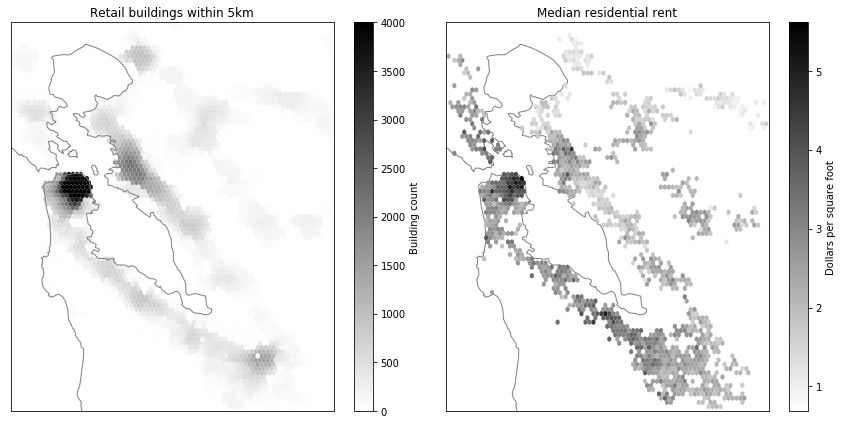

In [17]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

#####################
ax = axs[0]
ax.set_aspect(1.1)
ax.set_xlim((-122.6, -121.7))
ax.set_ylim((37.2, 38.2))
ax.set_title("Retail buildings within 5km")

states.plot(ax=ax, color='none', edgecolor='grey', zorder=2)

data = access
values = data.retail

def capped_median(C):
    return min(np.median(C), 4000)

hb = ax.hexbin(data.x, data.y, C=values, reduce_C_function=capped_median, 
                extent=extent, mincnt=1, gridsize=80, linewidths=0, cmap='binary', zorder=1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Building count')

ax.set_xticks([])
ax.set_xticklabels('')
ax.set_yticks([])
ax.set_yticklabels('')

#####################
ax = axs[1]
ax.set_aspect(1.1)
ax.set_xlim((-122.6, -121.7))
ax.set_ylim((37.2, 38.2))
ax.set_title("Median residential rent")

states.plot(ax=ax, color='white', edgecolor='grey', zorder=1)

data = rentals.loc[rentals.price_per_sqft < 10]
values = data.price_per_sqft
hb = ax.hexbin(data.lon, data.lat, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=5, gridsize=80, linewidths=0, cmap='binary', zorder=2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Dollars per square foot')

ax.set_xticks([])
ax.set_xticklabels('')
ax.set_yticks([])
ax.set_yticklabels('')

#####################
plt.tight_layout()
plt.show()

In [18]:
fig.savefig('../output/figure-1.pdf')

Resources
- https://github.com/UDST/pandana/blob/master/docs/tutorial.rst